## Patch to point extraction pipeline

As an input the script should take the path of the STAC collection for Sentinel-1 and Sentinel-2 patch extractions.

As a first step, the S1 and S2 STAC collections have to be split per EPSG, as openeo's `load_stac` can only handle one CRS in a STAC collection.
This can be accomplished with GFMap's `split_collection_by_epsg`, as shown in the code block below. 

NOTE: In the finale pipeline the STAC collections will be on /vitodata/worldcereal_data. For example purposes, my own public folder is used.

### Define spatial extent (in real pipeline we only need to define EPSG)

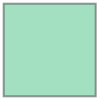

In [ ]:
from shapely.geometry import Polygon

bbox= [35.00842328556508,
  0.9147015574495287,
  35.014085328254765,
  0.9204010187474421]+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

bbox_dict = {'west': bbox[0], 'south': bbox[1], 'east': bbox[2], 'north': bbox[3]}

bbox_polygon = Polygon.from_bounds(bbox_dict['west'], bbox_dict['south'], bbox_dict['east'], bbox_dict['north'])

bbox_polygon

### Query STAC API to see how many items we find as a match (not needed in real pipeline as `load_stac` will take care of this)

In [ ]:
import pystac_client

stac_api_url = 'https://stac.openeo.vito.be/'

client = pystac_client.Client.open(stac_api_url)


search = client.search(ids=['2017_AF_One-Acre-Fund-MEL_POINT_110_2017_AF_OAF_POINT_110100_DESCENDING'],
                       collections=['worldcereal_sentinel1_patch_extractions'])

search.url_with_parameters()

items = search.get_all_items()

len(items)

/home/vverelst/anaconda3/envs/worldcereal/lib/python3.10/site-packages/pystac_client/item_search.py:903: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


2

In [4]:
items[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'stac_extensions': [],
 'id': '2017_AF_One-Acre-Fund-MEL_POINT_110_2017_AF_OAF_POINT_110100',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[35.014085328254765, 0.9147015574495287],
    [35.014085328254765, 0.9204010187474421],
    [35.00842328556508, 0.9204010187474421],
    [35.00842328556508, 0.9147015574495287],
    [35.014085328254765, 0.9147015574495287]]]},
 'bbox': [35.00842328556508,
  0.9147015574495287,
  35.014085328254765,
  0.9204010187474421],
 'properties': {'proj:epsg': 32636,
  'start_datetime': '2016-06-16T00:00:00Z',
  'end_datetime': '2018-05-02T00:00:00Z',
  'datetime': None,
  'created': '2024-11-27T16:17:16.637149Z',
  'updated': '2024-11-27T16:17:16.637149Z'},
 'links': [{'rel': 'self',
   'href': 'https://stac.openeo.vito.be/collections/worldcereal_sentinel2_patch_extractions/items/2017_AF_One-Acre-Fund-MEL_POINT_110_2017_AF_OAF_POINT_110100',
   'type': 'application/geo+json'},
  {'rel': 'parent',
   'href'

In [3]:
import pystac_client

stac_api_url = 'https://stac.openeo.vito.be/'

client = pystac_client.Client.open(stac_api_url)


search = client.search(ids=['2017_AF_One-Acre-Fund-MEL_POINT_110_2017_AF_OAF_POINT_110100'],
    collections=['worldcereal_sentinel2_patch_extractions'])

search.url_with_parameters()

items = search.get_all_items()

len(items)

1

### Query RDM API on the same bounding box

In [10]:
# from worldcereal.rdm_api import RdmInteraction

# rdm = RdmInteraction().authenticate()
# gdf = rdm.download_samples(geometry=bbox_polygon, subset=True, include_private=True)

# gdf

import geopandas as gpd

gdf = gpd.read_parquet('rdm_query.geoparquet')

gdf.sample_id.iloc[0]

'2017_AF_One-Acre-Fund-MEL_POINT_110_2017_AF_OAF_POINT_110100'

In [18]:
import openeo

c = openeo.connect('openeo-dev.vito.be').authenticate_oidc()

s2 = c.load_stac(url="https://stac.openeo.vito.be/collections/worldcereal_sentinel2_patch_extractions", spatial_extent=bbox_dict)

s2.execute_batch(
    title="test load stac",
    out_format='netcdf'
)

Authenticated using refresh token.
0:00:00 Job 'j-24121707671448279b1a35edbfb59c15': send 'start'
0:00:20 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:00:25 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:00:31 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:00:39 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:00:49 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:01:02 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:01:17 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:01:38 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:02:02 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:02:32 Job 'j-24121707671448279b1a35edbfb59c15': queued (progress 0%)
0:03:09 Job 'j-24121707671448279b1a35edbfb59c15': running (progress N/A)
0:03:56 Job 'j-24121707671448279b1a35edbfb59c15': running (progress N/A)
0:04:54 Job 'j-24121707671448279b1a35edbfb59c1

JobFailedException: Batch job 'j-24121707671448279b1a35edbfb59c15' didn't finish successfully. Status: error (after 0:04:55).

In [17]:
import xarray as xr

ds = xr.open_dataset('/home/vverelst/Downloads/openEO.nc')

ds['S1-SIGMA0-VV']

<xarray.DataArray 'S1-SIGMA0-VV' (t: 2, y: 33, x: 33)> Size: 4kB
[2178 values with dtype=uint16]
Coordinates:
  * t        (t) datetime64[ns] 16B 2016-06-29 2017-05-20
  * x        (x) float64 264B 7.235e+05 7.235e+05 ... 7.241e+05 7.241e+05
  * y        (y) float64 264B 1.018e+05 1.018e+05 ... 1.012e+05 1.012e+05
Attributes:
    long_name:     S1-SIGMA0-VV
    units:         
    grid_mapping:  crs

In [13]:
# from openeo_gfmap.utils import split_collection_by_epsg

# stac_path = '/data/users/Public/vincent.verelst/world_cereal/s1_s2_meteo_extraction/Sentinel2/stac/collection.json'
# output_dir = '/data/users/Public/vincent.verelst/world_cereal/s1_s2_meteo_extraction/Sentinel2/small-split-stac/'

# split_collection_by_epsg(stac_path, output_dir)

Next, the script will generate a list of all split STAC collections. As it isn't know up front how many different CRS were in the original STAC collection, it's not known into how many STAC collections it will be split.

An assertion is added to make sure that the number of S1 and S2 STAC collections is the same. (As normally both S1 and S2 STAC collection should have the same spatiotemporal extent.)

In [1]:
# Create a list of the paths to the split collections
import glob
s1_collection_paths = glob.glob("/data/users/Public/vincent.verelst/world_cereal/s1_s2_meteo_extraction/Sentinel1/split_stac/*/collection.json")
s2_collection_paths = glob.glob("/data/users/Public/vincent.verelst/world_cereal/s1_s2_meteo_extraction/Sentinel2/small-split-stac/*/collection.json")

assert len(s1_collection_paths) == len(s2_collection_paths), "Mismatch in number of collections"

The paths are stored in ordered lists. Again (since lists are ordered) we have to make sure that the order of both S1 and S2 lists is the same. 

In [2]:
def check_order_collection(s1_collection_paths, s2_collection_paths):
    for i in range(len(s1_collection_paths)):
        s1_epsg = s1_collection_paths[i].split('/')[-2]
        s2_epsg = s2_collection_paths[i].split('/')[-2]
        assert s1_epsg == s2_epsg, f"Order mismatch between {s1_epsg} and {s2_epsg}"

check_order_collection(s1_collection_paths, s2_collection_paths)

Next we can make a job dataframe which can be given as an input to the GFMapJobManager. We will create one batch job per UTM zone/CRS (to be seen if that is sufficiently small)

In [3]:
import pandas as pd
import pystac
from typing import List
from openeo_gfmap import Backend

def create_job_dataframe(backend: Backend, s1_collection_paths: List[str], s2_collection_paths: List[str]) -> pd.DataFrame:
    columns = ['backend_name', 'start_date', 'end_date', 's1_collection_path', 's2_collection_path', 'epsg', 'geometry']
    rows = []
    for idx, collection_path in enumerate(s1_collection_paths):
        coll = pystac.read_file(collection_path)
        start_date = coll.extent.temporal.intervals[0][0]
        end_date = coll.extent.temporal.intervals[0][1]
        geometry = coll.extent.spatial.bboxes
        epsg = collection_path.split('/')[-2][11:]

        rows.append(
            pd.Series(
                dict(zip(columns, [backend.value, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), collection_path, s2_collection_paths[idx], epsg, geometry]))
            )
        )

    return pd.DataFrame(rows)

job_df = create_job_dataframe(Backend.TERRASCOPE, s1_collection_paths, s2_collection_paths)

job_df

,backend_name,start_date,end_date,s1_collection_path,s2_collection_path,epsg,geometry
0,terrascope,2016-10-30,2018-05-03,/data/users/Public/vincent.verelst/world_cerea...,/data/users/Public/vincent.verelst/world_cerea...,32736,"[[34.453280157301236, -0.9129803702473933, 34...."


### RDM API Interaction

This is a placeholder to get a list of the URL to all geoparquets in the RDM intersection with the S1 and S2 STAC collections.  
We can use `query_ground_truth` to create a GeoParquet file to a specific output folder with all points in the RDM that are within a specified Polygon. The Polygon will be constructed from the job_df geometry.

### Create_datacube

Next, create the `create_datacube` function to be given to the GFMapJobManager is created. For this we cannot use worldcereal_classification's `worldcereal_preprocessed_inputs` in it's current form. Maybe best to discuss how we unify as much as possible the preprocessing of the different scripts.

METEO is loaded from a pre-composited STAC collection --> we have to think about how we keep this up-to-date (maybe include a trigger in the automatic RDM API interaction?)

In the final script we will include customizable job options, but we first need to figure out the optimal options 

In [4]:
import openeo
import pandas as pd

from openeo_gfmap import BackendContext, FetchType, TemporalContext
from openeo_gfmap.spatial import BoundingBoxExtent
from openeo_gfmap.preprocessing.compositing import median_compositing
from worldcereal.openeo.preprocessing import raw_datacube_DEM

def create_datacube(row: pd.Series, connection: openeo.Connection, provider=None, connection_provider=None):
    bbox = row.geometry[0]
    spatial_extent = BoundingBoxExtent(bbox[0], bbox[1], bbox[2], bbox[3])
    temporal_context = TemporalContext(row.start_date, row.end_date)  # In the end we'll probably don't need this. Leaving this in, just in case for now.

    backend = Backend.TERRASCOPE
    backend_context = BackendContext(backend)

    fetch_type = FetchType.TILE

    # The S1 and S2 cubes are loaded from their respective STAC collections
    s1_cube = connection.load_stac(row.s1_collection_path, temporal_extent=[row.start_date, row.end_date])
    s1_cube = median_compositing(s1_cube, period="month")
    
    s2_bands = [
            "S2-L2A-B01",
            "S2-L2A-B02",
            "S2-L2A-B03",
            "S2-L2A-B04",
            "S2-L2A-B05",
            "S2-L2A-B06",
            "S2-L2A-B07",
            "S2-L2A-B08",
            "S2-L2A-B8A",
            "S2-L2A-B11",
            "S2-L2A-B12"
        ]  # Not extracting SCL and distance to cloud, can easily be added if needed
    s2_cube = connection.load_stac(row.s2_collection_path, temporal_extent=[row.start_date, row.end_date])
    s2_cube = s2_cube.filter_bands(s2_bands)
    s2_cube = median_compositing(s2_cube, period="month")

    cube = s1_cube.merge_cubes(s2_cube)

    # For DEM we can use worldcereal_classification's raw_datacube_DEM
    dem_cube = raw_datacube_DEM(
        connection=connection,
        backend_context=backend_context,
        spatial_extent=spatial_extent,
        fetch_type=fetch_type,
        )
    dem_cube = dem_cube.resample_cube_spatial(s2_cube, method="bilinear")
    dem_cube = dem_cube.linear_scale_range(0, 65534, 0, 65534)  # Will not work for geoparquet output (openeo-devs are aware, but are not giving it priority)

    # METEO is loaded from a pre-composited STAC collection
    meteo_cube = connection.load_stac('/data/users/Public/vincent.verelst/world_cereal/agera5_monthly/stac/collection.json', spatial_extent=dict(spatial_extent), temporal_extent=[row.start_date, row.end_date])
    meteo_cube.result_node().update_arguments(featureflags={"tilesize": 1})
    meteo_cube = meteo_cube.rename_labels(
            dimension="bands", target=["AGERA5-PRECIP", "AGERA5-TMEAN"]
        )

    cube = s1_cube.merge_cubes(s2_cube)
    cube = cube.merge_cubes(dem_cube)
    cube = cube.merge_cubes(meteo_cube)
    
    # This is just a placeholder for the RDM API interaction function. In this example we just load in some random points from parquet as an example.
    geometries = connection.load_url('https://artifactory.vgt.vito.be/artifactory/auxdata-public/gfmap/32736-random-points.geoparquet', format='Parquet')

    cube = cube.aggregate_spatial(geometries, reducer='mean')

    return cube.create_job(
        title='Example patch to point in gfmap',
        out_format='Parquet'
    )

Next, we create a function to generate an output path. This is just an example of a folder structure. In the end, the parquet that comes out of this pipeline will have to be merged to the global Worldcereal parquet

In [5]:
def generate_output_path(output_dir, idx, row):
    return output_dir / row.epsg / 'point_timeseries.geoparquet'

Finally, create a post-job action to convert all values in the geoparquet values to uint16, as this isn't implemented in the OpenEO backend yet. 

In [6]:
import geopandas as gpd
from pathlib import Path
from typing import Optional

def post_job_action(
    job_items: List[pystac.Item], row: pd.Series, parameters: Optional[dict] = None
) -> list:
    for idx, item in enumerate(job_items):
        item_asset_path = Path(list(item.assets.values())[0].href)

        gdf = gpd.read_parquet(item_asset_path)

        # Convert the dates to datetime format
        gdf["date"] = pd.to_datetime(gdf["date"])

        # Convert band dtype to uint16 (temporary fix)
        # TODO: remove this step when the issue is fixed on the OpenEO backend
        bands = [
            "S2-L2A-B01",
            "S2-L2A-B02",
            "S2-L2A-B03",
            "S2-L2A-B04",
            "S2-L2A-B05",
            "S2-L2A-B06",
            "S2-L2A-B07",
            "S2-L2A-B08",
            "S2-L2A-B8A",
            "S2-L2A-B11",
            "S2-L2A-B12",
            "S1-SIGMA0-VH",
            "S1-SIGMA0-VV",
            "elevation",
            "AGERA5-PRECIP",
            "AGERA5-TMEAN",
        ]
        gdf[bands] = gdf[bands].fillna(65535).astype("uint16")

        gdf.to_parquet(item_asset_path, index=False)

    return job_items

Now we set up the GFMapJobManager and let the job(s) run.

In [7]:
from openeo_gfmap.manager.job_manager import GFMAPJobManager
from openeo_gfmap.backend import vito_connection
from pathlib import Path

output_dir = Path('/data/users/Public/vincent.verelst/world_cereal/test_patch_to_point_gfmap/')
job_db = output_dir / 'job_db.parquet'

job_manager = GFMAPJobManager(
    output_dir=output_dir,
    output_path_generator=generate_output_path,
    post_job_action=post_job_action,
    poll_sleep=60,
    n_threads=1,
    stac_enabled=False,  # Do we need a STAC collection for these geoparquet files?
)

job_manager.add_backend(
    Backend.TERRASCOPE.value, vito_connection, parallel_jobs=1
)

In [8]:
job_manager.run_jobs(df=job_df, start_job=create_datacube, output_file=job_db)

2024-09-19 12:55:06,337|openeo_gfmap.manager|INFO:  Starting ThreadPoolExecutor with 1 workers.
2024-09-19 12:55:06,339|openeo_gfmap.manager|INFO:  Creating and running jobs.


Authenticated using refresh token.


2024-09-19 13:00:42,486|openeo_gfmap.manager|INFO:  Job j-2409190c790144da9eba9dd28a9382a7 finished successfully, queueing on_job_done...
2024-09-19 13:00:44,640|openeo_gfmap.manager|INFO:  Parsed item timeseries.parquet from job j-2409190c790144da9eba9dd28a9382a7
2024-09-19 13:00:45,313|openeo_gfmap.manager|INFO:  Adding 1 items to the STAC collection...
2024-09-19 13:00:45,315|openeo_gfmap.manager|INFO:  Job j-2409190c790144da9eba9dd28a9382a7 and post job action finished successfully.
2024-09-19 13:01:42,781|openeo_gfmap.manager|INFO:  Quitting job tracking & waiting for last post-job actions to finish.
2024-09-19 13:01:42,783|openeo_gfmap.manager|INFO:  Exiting ThreadPoolExecutor.
2024-09-19 13:01:42,786|openeo_gfmap.manager|INFO:  All jobs finished running.
2024-09-19 13:01:42,788|openeo_gfmap.manager|INFO:  STAC was disabled, skipping generation of the catalogue.


Inspect the results:

In [11]:
import geopandas as gpd

results = gpd.read_parquet('/data/users/Public/vincent.verelst/world_cereal/test_patch_to_point_gfmap/32736/point_timeseries.geoparquet')
results.head()


,date,feature_index,S1-SIGMA0-VV,S1-SIGMA0-VH,S2-L2A-B01,S2-L2A-B02,S2-L2A-B03,S2-L2A-B04,S2-L2A-B05,S2-L2A-B06,S2-L2A-B07,S2-L2A-B08,S2-L2A-B8A,S2-L2A-B11,S2-L2A-B12,elevation,AGERA5-PRECIP,AGERA5-TMEAN,geometry,id
0,2016-11-01 00:00:00+00:00,0,0,0,1607,1292,1540,1578,2047,2687,2867,2884,5161,2441,1596,1376,65535,65535,POINT (34.76511 -0.37040),openEO_2017_AF_One-Acre-Fund-MEL_POINT_110_201...
1,2016-11-01 00:00:00+00:00,1,0,0,1608,1496,1648,1672,2226,3148,3435,3428,3506,3051,1836,1530,65535,65535,POINT (34.79640 -0.47529),openEO_2017_AF_One-Acre-Fund-MEL_POINT_110_201...
2,2016-11-01 00:00:00+00:00,2,0,0,837,820,1050,1040,1511,2442,2718,2746,3151,2369,1680,1232,65535,65535,POINT (34.45666 -0.55460),openEO_2017_AF_One-Acre-Fund-MEL_POINT_110_201...
3,2016-11-01 00:00:00+00:00,3,0,0,789,762,1052,802,1451,2965,3482,3372,3647,2445,1458,1336,65535,65535,POINT (34.45616 -0.67797),openEO_2017_AF_One-Acre-Fund-MEL_POINT_110_201...
4,2016-11-01 00:00:00+00:00,4,0,0,475,504,734,706,1128,2242,2597,2446,2778,1998,1280,1312,65535,65535,POINT (34.48585 -0.80910),openEO_2017_AF_One-Acre-Fund-MEL_POINT_110_201...
